In [5]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../GlacierLakeDetectionICESat2/GlacierLakeIS2ML/')

import shutil

from IS2ML_utils import *
from figscode import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# gdf_names = gpd.read_file('data/shapefiles/GRE_fullnames_GIMP_merged.shp')
gdf_basins = gpd.read_file('data/shapefiles/GRE_basins_merged_GRIMP.shp')# 
gdf_basins['geometry'] = gdf_basins['geometry'].simplify(1000, preserve_topology=False)
gdf_gre_full = gdf_basins.dissolve()

# df = pd.read_csv('data/GLD3_GrIS_lakestats.csv')
df = pd.read_csv('data/FLUID-SuRRF_GrIS2019-23_lakestats.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs='EPSG:3413')
gdfg = gdf[gdf.label=='good_lake'].copy()
gdfg['lid'] = gdfg.apply(lambda x: '_'.join(x.lake_id.split('_')[4:]), axis=1)

rgt_gre = gpd.read_file('data/shapefiles/rgts_gris_clipped.shp')

labs_locs = gpd.GeoSeries([Polygon(chaikin_smooth(gdf_gre_full.buffer(100000).simplify(30000).exterior.iloc[0]))], crs=gdf_gre_full.crs).exterior.iloc[0]

from scipy.spatial import cKDTree
k_nearest = 30
quantile = 0.75
maxdist = 1e5 # 100 km
gdfg[['x', 'y']] = gdfg.get_coordinates()
coordinates = gdfg[['x', 'y']].values
kdtree = cKDTree(coordinates)
distances, indices = kdtree.query(coordinates, k=k_nearest)
neighbor_max_depths = gdfg['max_depth'].values[indices]
neighbor_max_depths[distances > maxdist] = np.nan
mean_neighbor_depth = pd.DataFrame(neighbor_max_depths).apply(lambda x: (x[x >= x.quantile(quantile)]).mean(), axis=1)
gdfg['mean_neighbor_depth'] = mean_neighbor_depth

a: NO, HUMBOLDT_GLETSCHER > "Sermersuaq (Humboldt)" (2020), 79.50320, -64.02579
b: NO, PETERMANN_GLETSCHER > "Petermann Gletsjer" (2019), 80.57140, -59.37086
c: NO, RYDER_GLETSCHER > "Ryder Gletsjer" (2023), 81.09445, -49.61909
d: NO, ACADEMY > "Academy Gletsjer" (2022), 81.33318, -31.93221
e: NE, NIOGHALVFJERDSFJORDEN > "Nioghalvfjerdsbrae (79 N)" (2019), 79.13148, -23.66437
f: NE, ZACHARIAE_ISSTROM > "Zachariae Isstrøm" (2019), 79.10630, -22.03080
g: NE, STORSTROMMEN > "Storstrømmen" (2021), 77.51659, -23.75417
h: NE, WALTERSHAUSEN > "Waltershausen Gletsjer" (2021), 74.21166, -26.22267
i: CE, KONG_CHRISTIAN > "Christian IV Gletsjer" (2023), 68.81883, -30.47057
j: CE, KANGERLUSSUAQ > "Kangerlussuaq Gletsjer" (2022), 68.76730, -33.47235
k: SE, HELHEIMGLETSCHER > "Helheim Gletsjer" (2021), 66.46266, -38.46161
l: SE, SKINFAXE > "Apusiigajik (Skinfaxe)" (2021), 63.32042, -42.08879
m: SW, KANGIATA_NUNAATA_SERMIA > "Kangiata Nunaata Sermia" (2022), 64.32671, -48.78513
n: SW, SAQQAP-MAJORQAQ

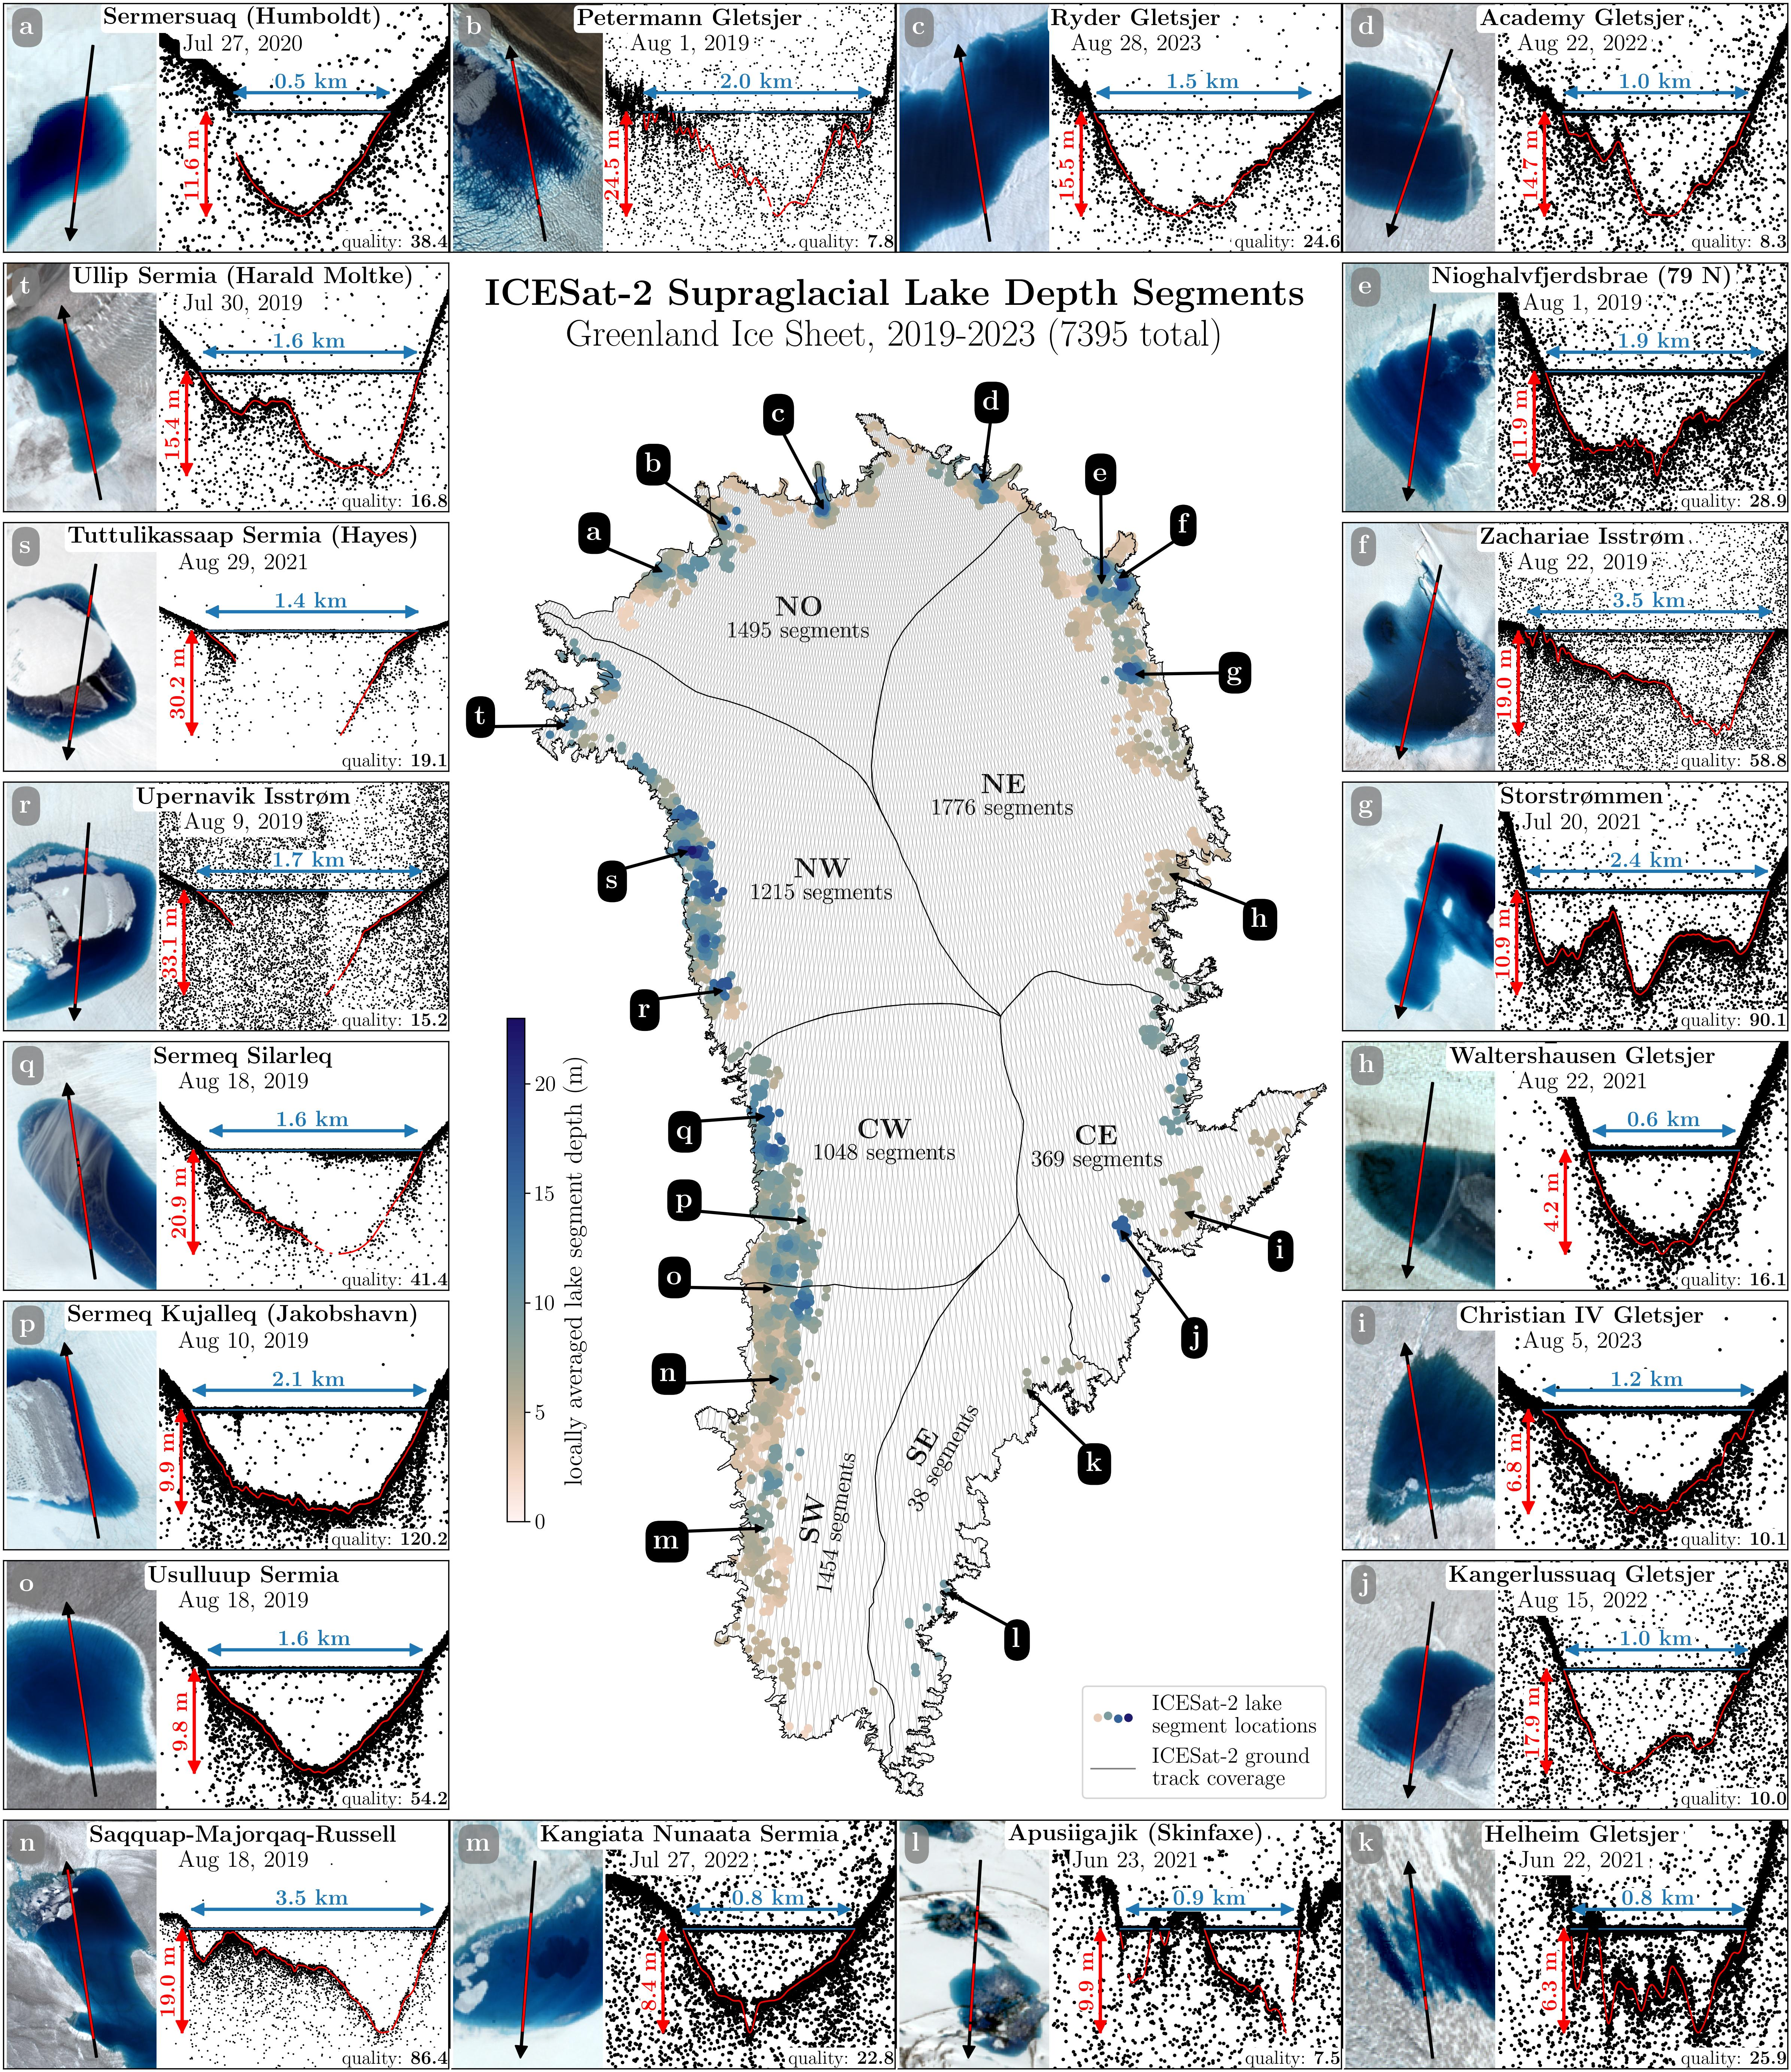

In [57]:
plt.close('all')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima",
    'font.size': 14,
})

layout_parms = {'pad': 0.3, 'h_pad': 0.5, 'w_pad': 0.05}

bdr = 'data/IS2/'
# bdr_source = '/Users/parndt/jupyterprojects/GLD3_complete/GrIS/detection_out_data/good_lake/'

letterkey = 's'
pars = {
    'a': [{'fn': 'lake_097420_GrIS_2020_simplified_GRE_2200_NO_ATL03_20200727012637_04840805_006_01_gt2l_0000.h5', 'gamma_value': 1.8}, {'x': -496852.969, 'y': -1004886.077},
          {'title': 'Sermersuaq (Humboldt)'}],
    'b': [{'fn': 'lake_099737_GrIS_2019_simplified_GRE_2200_NO_ATL03_20190801045056_05210404_006_02_gt3l_0003.h5', 'gamma_value': 1.1, 'max_cloud_prob': 30}, {'x': -389987.092, 'y': -880209.219},
          {'title': 'Petermann Gletsjer'}],
    'c': [{'fn': 'lake_097744_GrIS_2023_simplified_GRE_2200_NO_ATL03_20230828050404_10542004_006_02_gt1l_0001.h5', 'max_cloud_prob': 5}, {},
          {'title': 'Ryder Gletsjer'}],
    'd': [{'fn': 'lake_099109_GrIS_2022_simplified_GRE_2200_NO_ATL03_20220822111641_09401604_006_01_gt2r_0003.h5', 'max_cloud_prob': 5}, {'x': 230852.770, 'y': -765710.064},
          {'title': 'Academy Gletsjer'}],
    'e': [{'fn': 'lake_097699_GrIS_2019_simplified_GRE_2200_NE_ATL03_20190801155607_05280405_006_02_gt2l_0010.h5', 'gamma_value': 1.0}, {'x': 429317.972, 'y': -898020.199},
          {'title': 'Nioghalvfjerdsbrae (79 N)'}],
    'f': [{'fn': 'lake_099490_GrIS_2019_simplified_GRE_2200_NE_ATL03_20190822144852_08480405_006_02_gt3l_0015.h5'}, {'x': 576894.661, 'y': -994708.374},
          {'title': 'Zachariae Isstrøm'}],
    'g': [{'fn': 'lake_094135_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210720053125_04061205_006_01_gt3r_0045.h5', 'gamma_value': 1.4}, {'x': 673582.836, 'y': -1261873.069},
          {'title': 'Storstrømmen'}],
    'h': [{'fn': 'lake_098355_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210822035912_09091205_006_01_gt1r_0016.h5', 'gamma_value': 0.8}, {'x': 721926.923, 'y': -1712236.411},
          {'title': 'Waltershausen Gletsjer'}],
    'i': [{'fn': 'lake_098782_GrIS_2023_simplified_GRE_2200_CE_ATL03_20230805052259_07032003_006_02_gt3l_0006.h5', 'gamma_value': 0.8}, {'x': 755004.457, 'y': -2315265.293},
          {'title': 'Christian IV Gletsjer'}],
    'j': [{'fn': 'lake_098991_GrIS_2022_simplified_GRE_2200_CE_ATL03_20220815111248_08331605_006_01_gt1r_0002.h5', 'gamma_value': 1.5}, {'x': 597250.066, 'y': -2473019.685},
          {'title': 'Kangerlussuaq Gletsjer'}],
    'k': [{'fn': 'lake_099377_GrIS_2021_simplified_GRE_2200_SE_ATL03_20210622185325_13741103_006_01_gt1r_0001.h5', 'gamma_value': 1.3, 'max_cloud_prob': 30, 'imagery_shift_days': 5}, {},
          {'title': 'Helheim Gletsjer'}],
    'l': [{'fn': 'lake_099383_GrIS_2021_simplified_GRE_2200_SE_ATL03_20210623073819_13821105_006_01_gt2r_0001.h5', 'gamma_value': 1.6}, {'x': 269019.155, 'y': -3022615.628},
          {'title': 'Apusiigajik (Skinfaxe)'}],
    'm': [{'fn': 'lake_098114_GrIS_2022_simplified_GRE_2200_SW_ATL03_20220727130304_05441605_006_02_gt1r_0009.h5', 'gamma_value': 1.0}, {'x': -369631.686, 'y': -2841961.406},
          {'title': 'Kangiata Nunaata Sermia'}],
    'n': [{'fn': 'lake_098624_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190818034635_07800403_006_02_gt2l_0008.h5', 'gamma_value': 1.1, 'max_cloud_prob': 10}, {'x': -359453.984, 'y': -2539174.752},
          {'title': 'Saqquap-Majorqaq-Russell'}],
    'o': [{'fn': 'lake_095271_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190818034635_07800403_006_02_gt1l_0001.h5', 'gamma_value': 1.0, 'max_cloud_prob': 10}, {'x': -351820.707, 'y': -2363609.381},
          {'title': 'Usulluup Sermia'}],
    'p': [{'fn': 'lake_091299_GrIS_2019_simplified_GRE_2200_CW_ATL03_20190810040312_06580403_006_02_gt3l_0025.h5', 'gamma_value': 1.0}, {},
          {'title': 'Sermeq Kujalleq (Jakobshavn)'}],
    'q': [{'fn': 'lake_097816_GrIS_2019_simplified_GRE_2200_CW_ATL03_20190818034635_07800403_006_02_gt1l_0001.h5'}, {},
          {'title': 'Sermeq Silarleq'}],
    'r': [{'fn': 'lake_099475_GrIS_2019_simplified_GRE_2200_NW_ATL03_20190809171345_06510405_006_02_gt1l_0000.h5', 'gamma_value': 1.2}, {},
          {'title': 'Upernavik Isstrøm'}],
    's': [{'fn': 'lake_098939_GrIS_2021_simplified_GRE_2200_NW_ATL03_20210829054228_10171205_006_01_gt1r_0006.h5', 'max_cloud_prob': 20, 'imagery_shift_days': 0}, {},
          {'title': 'Tuttulikassaap Sermia (Hayes)'}],
    't': [{'fn': 'lake_098461_GrIS_2019_simplified_GRE_2200_NW_ATL03_20190730053649_04910403_006_02_gt2l_0004.h5'}, {'x': -702951.448, 'y': -1343294.690},
          {'title': 'Ullip Sermia (Harald Moltke)'}],
    # 'u': [{'fn': 'lake_099138_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210822144839_09161203_006_01_gt2r_0011.h5'}, {},
    #       {'title': 'Wordie-Vibeke'}],
    # 'v': [{'fn': 'lake_099373_GrIS_2019_simplified_GRE_2200_NE_ATL03_20190803021956_05500403_006_02_gt2l_0002.h5', 'gamma_value': 1.8}, {},
    #       {'title': 'Nioghalvfjerdsfjorden'}],
    # 'x': [{'fn': 'lake_098133_GrIS_2022_simplified_GRE_2200_NW_ATL03_20220807001855_07041603_006_01_gt3r_0025.h5'}, {},
    #       {'title': 'Kjer Gletsjer'}],
    # 'y': [{'fn': 'lake_095931_GrIS_2019_simplified_GRE_2200_NW_ATL03_20190805043712_05820403_006_02_gt1l_0003.h5'}, {},
    #       {'title': 'Alison Gletscher'}],
    # 'z': [{'fn': 'lake_099138_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210822144839_09161203_006_01_gt2r_0011.h5'}, {},
    #       {'title': 'Wordie-Vibeke'}],
}
# pars = {letterkey: pars[letterkey]}

region_locs = {
    'NO': {'x': -120431.650, 'y': -1168898.581},
    'NW': {'x': -78158.149, 'y': -1645985.187},
    'NE': {'x': 251624.352, 'y': -1491381.416},
    'CW': {'x': 36766.839, 'y': -2120122.349},
    'CE': {'x': 421873.448, 'y': -2131883.238},
    # 'SW': {'x': -522363.019, 'y': -3107457.409, 'x_arr': -88726.524, 'y_arr': -2964956.181},
    'SW': {'x': -69531.088, 'y': -2805404.732},
    # 'SE': {'x': 506630.926, 'y': -2916540.146, 'x_arr': 106998.394, 'y_arr': -2711937.862},
    'SE': {'x': 127233.161, 'y': -2683275.198},
}

txt_rot = {
    'NO': 0,
    'NW': 0,
    'NE': 0,
    'CW': 0,
    'CE': 0,
    # 'NO': 10,
    # 'NW': 13,
    # 'NE': 6,
    # 'CW': 3,
    # 'CE': -5,
    'SW': 80,
    'SE': 60
}

# collect the data to pass to plotting functions
for key, lst in pars.items():
    params = lst[0]
    params['fn'] = bdr + params['fn']
    # if not os.path.isfile(params['fn']):
    #     shutil.copyfile(params['fn'].replace(bdr, bdr_source), params['fn'])
    #     print('copied file')

    lk = dictobj(read_melt_lake_h5(params['fn']))
    params['imagery_filename'] = ('data/imagery/' + lk.imagery_info['product_id'] + '_' +
                                  params['fn'].split('/')[-1].replace('.h5','') + '.tif' 
                                  if hasattr(lk, 'imagery_info') else None)
    linfo = gdfg[gdfg.lid == lk.lake_id].iloc[0]
    print('%s: %s, %s > "%s" (%s), %.5f, %.5f' % (key, linfo.basin, linfo.sub_basin, lst[2]['title'], linfo.melt_season, linfo.lat, linfo.lon))
    
    params['xlm'] = [None, None]
    params['ylm'] = [None, None]
    pt_loc = shapely.geometry.Point(lst[1]['x'], lst[1]['y']) if 'x' in lst[1] else gpd.GeoSeries(shapely.geometry.Point(lk.lon, lk.lat), crs='EPSG:4326').to_crs(gdf_gre_full.crs).iloc[0]
    # pt_loc = gpd.GeoSeries(shapely.geometry.Point(lk.lon, lk.lat), crs='EPSG:4326').to_crs(gdf_gre_full.crs)
    lst[1] = find_closest_point(pt_loc, labs_locs)
    lst[2]['date'] = datetime.strftime(datetime.strptime(lk.date_time, '%Y-%m-%dT%H:%M:%SZ'), '%b %-d, %Y')

##########################################
# CREATE FIGURE AND AXES
fig = plt.figure(figsize=[16,18.5], dpi=60)
ny = 8
nx = 4
gs = fig.add_gridspec(ny, nx)
axs = []
axmid = fig.add_subplot(gs[1:ny-1, 1:nx-1])
axmid.axis('off')
ax0 = axmid.inset_axes([0, 0, 1, 0.93])
axtit = axmid.inset_axes([0, 0.93, 1, 0.07])
del axmid
axtit.axis('off')
axs.append(ax0)
axboxs = []
xs = list(range(nx)) + [nx-1]*(ny-2) + list(range(nx-1,-1,-1)) + [0]*(ny-2)
ys = [0]*nx + list(range(1,ny)) + [ny-1]*(nx-2) + list(range(ny-1,0,-1))
for i in range(len(xs)):
    axboxs.append(fig.add_subplot(gs[ys[i], xs[i]]))
    axboxs[-1].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    axboxs[-1].patch.set_facecolor('none')
    for spine in axboxs[-1].spines.values():
        spine.set_zorder(100)
        
for axbx in axboxs:
    axs.append(axbx.inset_axes([0, 0, 0.35, 1]))
    axs.append(axbx.inset_axes([0.35, 0, 0.65, 1]))

ax = axs[0]
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, 
               labelbottom=False, labelleft=False)

for iax, ax in enumerate(axs[1:]):
    ax.axis('off')
    
fig.tight_layout(**layout_parms)

tit = '\\textbf{ICESat-2 Supraglacial Lake Depth Segments}\nGreenland Ice Sheet, 2019-2023 (%i total)' % len(gdfg)
axtit.text(0.5, 0.5, tit, ha='center', va='center', transform=axtit.transAxes, fontsize=24)

# get the optimal imagery axis aspect ratio
axbx = axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
axis_aspect = axbx.height / axbx.width

ax = axs[0]
crsp = 'EPSG:3413'
gdfp = gdf.to_crs(crsp)
gdfmp = gdf_basins.to_crs(crsp)
# gdf_gre_full.to_crs(crsp).plot(color=[0.9]*3, ax=ax)
# gdfp.plot(ax=ax, markersize=3, color='r', alpha=1)
gdfmp.boundary.plot(color='k', ax=ax, lw=0.6, zorder=10)

rgt_color = 'gray'
rgt_gre.plot(ax=ax, lw=0.4, color=rgt_color, alpha=0.5, zorder=8)
hdl_rgt, = ax.plot([0,0], [0,0], lw=1, color=rgt_color, alpha=1, label='ICESat-2 ground\ntrack coverage')
gdfscatt = gdfg.copy().sort_values(by='mean_neighbor_depth').reset_index(drop=False)
vmin = 0
vmax = np.ceil(gdfscatt.mean_neighbor_depth.max())
cmap = cmc.lapaz_r
# cmap = cmc.buda_r
# gdfscatt.plot(ax=ax, markersize=10, alpha=1, column='mean_neighbor_depth', cmap=cmap, vmin=vmin, vmax=vmax, edgecolors='k', linewidth=0.1)
gdfscatt.plot(ax=ax, markersize=30, alpha=1, column='mean_neighbor_depth', cmap=cmap, vmin=vmin, vmax=vmax, 
                          edgecolors='none', linewidth=0, zorder=9)
npts = 4
hdl_scatt = ax.scatter([0]*npts, [0]*npts, s=30, c=np.linspace(vmin+3,vmax-1,npts), edgecolors='none', linewidth=0, 
                       cmap=cmap, label='ICESat-2 lake\nsegment locations', vmin=vmin, vmax=vmax)

cax = ax.inset_axes([0.06, 0.2, 0.02, 0.35])
smap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
smap._A = []
cbar = plt.colorbar(smap, cax=cax, orientation='vertical')
cax.set_ylabel('locally averaged lake segment depth (m)', fontsize=16)

ax.set_ylim((-3332000, -713000))
ax.set_xlim((-750000, 858000))

ax.legend(handles=[hdl_scatt, hdl_rgt], scatterpoints=npts, loc='lower right')

# get region counts
region_counts = gdfg.groupby(by='basin')['lake_id'].count().to_dict()
name_sz = plt.rcParams['font.size']+4
count_sz = plt.rcParams['font.size']+1
# show basin labels and lake counts
for i in range(len(gdfmp)):
    x = gdfmp.iloc[i]
    region = x.SUBREGION1
    lake_count = region_counts[region] if region in region_counts.keys() else 0
    thename = '\\textbf{%s}' % region
    lakequant = 'segment' if lake_count == 1 else 'segments'
    thecount = '%i %s' % (lake_count, lakequant)
    if region in region_locs.keys():
        locs = region_locs[region]
        xytext = [locs['x'], locs['y']]
        ax.annotate(text=thename, xy=xytext, ha='center',va='bottom',color='k',fontsize=name_sz, 
                    rotation=txt_rot[region], rotation_mode='anchor')
        ax.annotate(text=thecount, xy=xytext, ha='center',va='top',color='k',fontsize=count_sz, 
                    rotation=txt_rot[region], rotation_mode='anchor')
        if 'x_arr' in locs.keys():
            xyarr = [locs['x_arr'], locs['y_arr']]
            frac = 0.2
            xystart = np.array(xytext) + frac*(np.array(xyarr) - np.array(xytext)) 
            ax.annotate(' ', xy=xyarr, xytext=xystart,ha='center',va='center',color='k',fontsize=count_sz,
                         arrowprops=dict(width=1, headwidth=7, headlength=7, color='k'),zorder=1000)
        else:
            ax.annotate(text=thecount, xy=xytext, ha='center',va='top',color='k',fontsize=count_sz, 
                        rotation=txt_rot[region], rotation_mode='anchor')
    else:
        ax.annotate(text=thename, xy=x.geometry.centroid.coords[0], ha='center',va='bottom',
                                           color='k',fontsize=name_sz, weight='bold')
        ax.annotate(text=thecount, xy=x.geometry.centroid.coords[0], ha='center',va='top',
                                           color='k',fontsize=count_sz)

# labs_locs.plot(ax=ax, color='gray', lw=0.5)

fsz_letters = plt.rcParams['font.size']+3
color_letters = 'gray'

##########################################
# LAKE PLOTS (ICESat-2 and imagery)

settings = {
    're_download': False,  # to avoid, re-downloading scenes that were already acquired
    'stretch_color': True,  # to stretch the RGB values from their 1st to 99th percentiles
    'img_aspect': axis_aspect,  # adjust to fill max space in the figure
    'increase_linewidth': 1.0,  # for depth data linewidth
    'increase_gtwidth': 1.5,  # for ground track arrow size
    'buffer_factor': 1.4,  # how far the image extent is buffered around the ground track (fraction of ground track bbox)
    'rasterize_scatter': True
}

ax_map = axs[0] 
thesubplots = [[pars[k][0], ik*2+1, pars[k][1], pars[k][2]] for ik, k in enumerate(pars.keys())]

for i_plot,loc in enumerate(thesubplots):
    coords = plot_IS2_imagery(**loc[0], axes=axs[loc[1]:loc[1]+2], **settings)
    plot_coords(coords, ax=ax_map, crs_dst=crsp, text=r'\textbf{%s}' % chr(ord('a')+i_plot), annot_loc=loc[2], color='black')
    add_letter(ax=axs[loc[1]], text=r'\textbf{%s}' % chr(ord('a')+i_plot), fs=fsz_letters, col=color_letters, alpha=0.8)

bbox_tit = dict(facecolor='white', alpha=1.0, boxstyle='round,pad=0.15,rounding_size=0.25', lw=0)
for i_plot, loc in enumerate(thesubplots):
    ip = int((loc[1]-1)/2)
    axb = axboxs[ip]
    ypos = 0.895
    xpos = 0.54
    txt = '\\textbf{%s}' % loc[3]['title']
    axb.text(xpos, ypos, txt, ha='center', va='bottom', transform=axb.transAxes, fontsize=plt.rcParams['font.size']+1, bbox=bbox_tit, zorder=100)
    txt = loc[3]['date']
    axb.text(xpos, ypos-0.02, txt, ha='center', va='top', transform=axb.transAxes, fontsize=plt.rcParams['font.size']+1, bbox=bbox_tit, zorder=100)
    
adjust_down = 0.11
axbx = axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
axis_aspect = axbx.height / axbx.width
for iax, ax in enumerate(axs):
    if iax % 2 == 1:
        xxl = ax.get_xlim()
        yyl = ax.get_ylim()
        yyr = yyl[1] - yyl[0]
        asp = axis_aspect
        yl = (yyl[0] + adjust_down * yyr, yyl[1])
        ydiff = yl[1] - yl[0]
        xdiff = ydiff/asp
        xl = (np.mean(xxl) - xdiff/2, np.mean(xxl) + xdiff/2)
        ax.set_xlim(xl)
        ax.set_ylim(yl)

figfn = 'figures/fig01_map-icesat2-segments.jpg'
for savefn in [figfn, figfn.replace('.jpg', '.pdf')]:
    fig.savefig(savefn, dpi=300, bbox_inches='tight', pad_inches=0.03)
fig.savefig(figfn.replace('.jpg','_lowres.jpg'), dpi=30, bbox_inches='tight', pad_inches=0.03)
plt.close(fig)
display(Image(figfn))

## interactive figure below for querying axis positions for labels and showing lake plots sorted by different attributes, and for a spatial selection in the plot

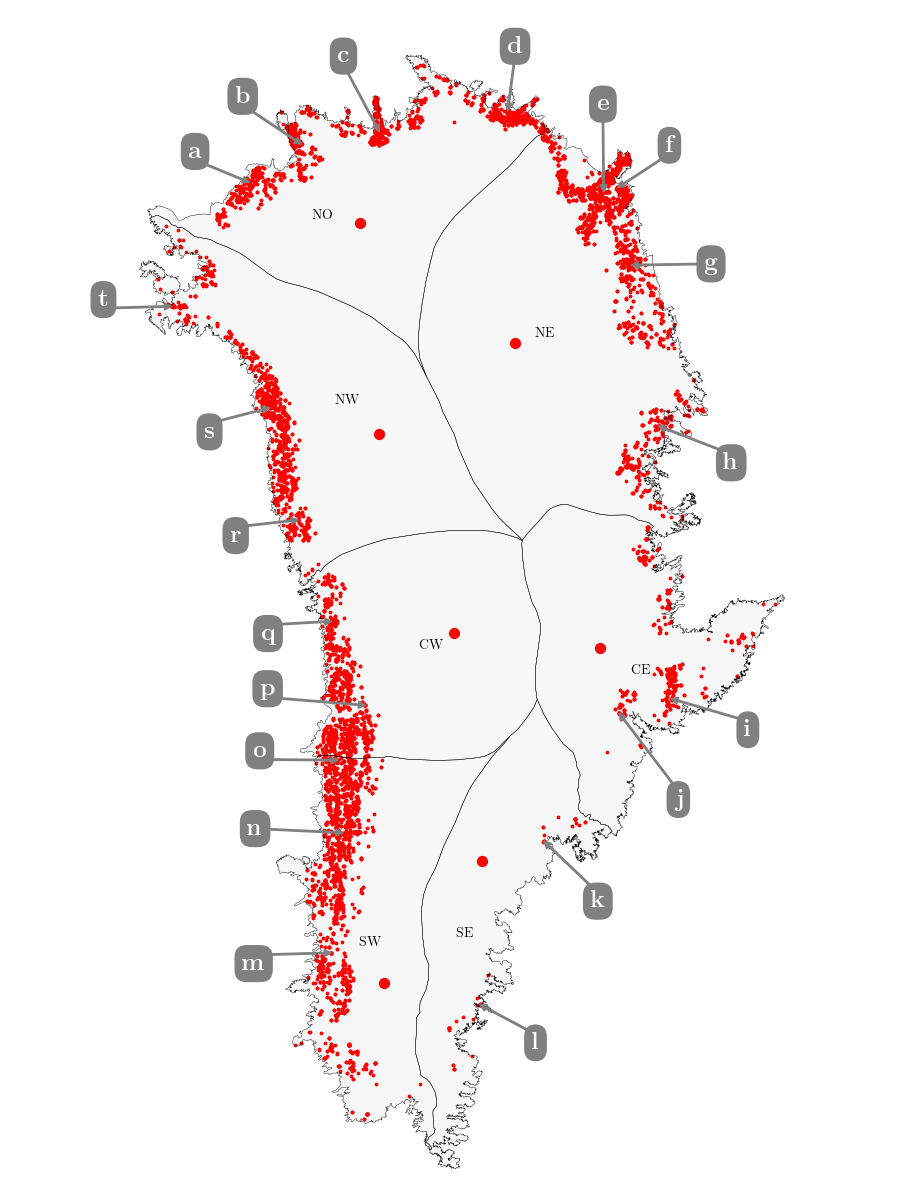

In [45]:
plt.close('all')
fig,ax = plt.subplots(figsize=[9,12])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, 
               labelbottom=False, labelleft=False)
crsp = 'EPSG:3413'
gdfp = gdf.to_crs(crsp)
gdfmp = gdf_basins.to_crs(crsp)
gdf_gre_full.to_crs(crsp).plot(color=[0.9]*3, ax=ax, markersize=1,alpha=0.3)
gdfmp.boundary.plot(color='k', ax=ax, lw=0.3)
gdfmp.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.representative_point().coords[0], 
                                       ha='center',va='center',color='k',fontsize=10),axis=1)
gdfp.plot(ax=ax, markersize=3, color='r', alpha=1)
# labs_locs.plot(ax=ax, color='gray', lw=0.5)

fig2, axs = plt.subplots(ncols=2)

for i_plot,loc in enumerate(thesubplots):
    coords = plot_IS2_imagery(**loc[0], axes=list(axs), **settings)
    plot_coords(coords, ax=ax, crs_dst=crsp, text=r'\textbf{%s}' % chr(ord('a')+i_plot), annot_loc=loc[2], color=color_letters)
    add_letter(ax=axs[0], text=r'\textbf{%s}' % chr(ord('a')+i_plot), fs=fsz_letters, col=color_letters, alpha=0.5)

for locs in region_locs.values():
    ax.scatter(locs['x'], locs['y'], s=50, color='r')

ax.set_xlim((-694000, 858000))
ax.set_ylim((-3332000, -713000))

plt.close(fig2)

fig.tight_layout()

# to get coordinates from clicks
coords = []
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print("'x': %.3f, 'y': %.3f" % (ix,iy))
    global coords
    coords.append((ix,iy))
    if len(coords) > 100:
        fig.canvas.mpl_disconnect(cid)
    return coords
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [19]:
ax.get_ylim()

(-3332175.9268949674, -3056979.871998297)

In [ ]:
(-694000, 858000)
(-3332000, -713000)

In [49]:
print("{'x': %.3f, 'y': %.3f}" % (coords[-1][0], coords[-1][1]))

{'x': 251624.352, 'y': -1491381.416}


In [ ]:
axxl = ax.get_xlim()
axyl = ax.get_ylim()
xvls = [axxl[i] for i in [0,1,1,0,0]]
yvls = [axyl[i] for i in [0,0,1,1,0]]
poly = Polygon(list(zip(xvls,yvls)))

In [ ]:
(gdfgg.sub_basin == 'NIOGHALVFJERDSFJORDEN').sum()

In [ ]:
axxl = ax.get_xlim()
axyl = ax.get_ylim()

df = pd.read_csv('data/GLD3_GrIS_lakestats.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs='EPSG:3413')
gdfgg = gdf[gdf.label=='good_lake']

# gdfgg = gdfgg[gdfgg.melt_season==2023]
# gdfgg = gdfgg[gdfgg.basin=='CE']
# gdfgg = gdfgg[gdfgg.sub_basin=='NIOGHALVFJERDSFJORDEN']
gdfgg = gdfgg[gdfgg.geometry.within(poly)]

gdfg_sort = gdfgg.sort_values(by='depth_quality_sort', ascending=False)

# gdfg_sort = gdfgg.sort_values(by='max_depth', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='depth_mean', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='depth_median', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='surface_elevation', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='conf_median', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='conf_mean', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='conf_q90', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='length_water', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='total_length', ascending=False)
# gdfg_sort = gdfgg.sort_values(by='ratio_water', ascending=False)


img_source = '/Users/parndt/jupyterprojects/GLD3_complete/GrIS/detection_context/good_lake/'

start = 0
n_imgs = 2
for i in np.arange(start, start+n_imgs):
    fnimg = img_source + gdfg_sort.iloc[i].lake_id + '_context.jpg'
    fn = gdfg_sort.iloc[i].lake_id + '.h5'
    print("\n'%s' # %s, %s, %s" % (fn, gdfg_sort.iloc[i].basin, gdfg_sort.iloc[i].melt_season, gdfg_sort.iloc[i].sub_basin))
    display(Image(fnimg))

In [ ]:
selfns = [
'lake_091049_GrIS_2019_simplified_GRE_2200_CW_ATL03_20190814035453_07190403_006_02_gt3l_0025.h5', # CW, 2019, JAKOBSHAVN_ISBRAE, high qual
'lake_091299_GrIS_2019_simplified_GRE_2200_CW_ATL03_20190810040312_06580403_006_02_gt3l_0025.h5', # CW, 2019, JAKOBSHAVN_ISBRAE, high qual
'lake_091427_GrIS_2021_simplified_GRE_2200_NW_ATL03_20210820062447_08801205_006_01_gt2l_0007.h5', # NW, 2021, ISSUUARSUIT_SERMIA, high qual
'lake_093699_GrIS_2019_simplified_GRE_2200_CW_ATL03_20190818034635_07800403_006_02_gt3l_0021.h5', # CW, 2019, NORDENSKIOLD_GLETSCHER, high qual
'lake_094135_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210720053125_04061205_006_01_gt3r_0045.h5', # NE, 2021, STORSTROMMEN, very high qual / shape
'lake_094633_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190818034635_07800403_006_02_gt2r_0010.h5', # SW, 2019, SAQQAP-MAJORQAQ-SOUTHTERRUSSEL_SOUTHQUARUSSEL, qual / weak beam / shape
'lake_098624_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190818034635_07800403_006_02_gt2l_0008.h5' # SW, 2019, SAQQAP-MAJORQAQ-SOUTHTERRUSSEL_SOUTHQUARUSSEL, long / shape
'lake_095271_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190818034635_07800403_006_02_gt1l_0001.h5', # SW, 2019, USULLUUP_SERMIA, high qual, nice round
'lake_095766_GrIS_2019_simplified_GRE_2200_CW_ATL03_20190814035453_07190403_006_02_gt1l_0002.h5', # CW, 2019, JAKOBSHAVN_ISBRAE, deep / high qual
'lake_095931_GrIS_2019_simplified_GRE_2200_NW_ATL03_20190805043712_05820403_006_02_gt1l_0003.h5', # NW, 2019, ALISON_GLETSCHER, deep / high qual / round
'lake_096376_GrIS_2020_simplified_GRE_2200_NW_ATL03_20200830230300_10170805_006_01_gt1l_0001.h5', # NW, 2020, HAYES_GLETSCHER_N_NN, deep high_qual
'lake_097275_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210720053125_04061205_006_01_gt3l_0032.h5', # NE, 2021, STORSTROMMEN, shape
'lake_097420_GrIS_2020_simplified_GRE_2200_NO_ATL03_20200727012637_04840805_006_01_gt2l_0000.h5', # NO, 2020, HUMBOLDT_GLETSCHER, cliff?? / shape
'lake_099373_GrIS_2019_simplified_GRE_2200_NE_ATL03_20190803021956_05500403_006_02_gt2l_0002.h5', # NE, 2019, NIOGHALVFJERDSFJORDEN, deepest
'lake_098939_GrIS_2021_simplified_GRE_2200_NW_ATL03_20210829054228_10171205_006_01_gt1r_0006.h5', # NW, 2021, HAYES_GLETSCHER_N_NN, close to deepest
'lake_099475_GrIS_2019_simplified_GRE_2200_NW_ATL03_20190809171345_06510405_006_02_gt1l_0000.h5', # NW, 2019, UPERNAVIK_ISSTROM_C, deepest
'lake_099501_GrIS_2019_simplified_GRE_2200_NO_ATL03_20190902161841_10170404_006_02_gt1l_0000.h5', # NO, 2019, RYDER_GLETSCHER, deep / long / shape
'lake_098322_GrIS_2019_simplified_GRE_2200_NW_ATL03_20190805043712_05820403_006_02_gt2l_0017.h5', # NW, 2019, ILLULLIP_SERMIA, deep, ogive shape
'lake_099416_GrIS_2019_simplified_GRE_2200_NW_ATL03_20190907030457_10850403_006_02_gt2r_0007.h5', # NW, 2019, HAYES_GLETSCHER_N_NN, deep / ice cover very cool looking
'lake_099737_GrIS_2019_simplified_GRE_2200_NO_ATL03_20190801045056_05210404_006_02_gt3l_0003.h5', # NO, 2019, PETERMANN_GLETSCHER, deep / long / petermann tongue
'lake_097816_GrIS_2019_simplified_GRE_2200_CW_ATL03_20190818034635_07800403_006_02_gt1l_0001.h5', # CW, 2019, SERMEQ_SILARLEQ, deep, bathy with ice cover
'lake_099759_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190814035453_07190403_006_02_gt2r_0012.h5', # SW, 2019, SERMILIGAARSSUK_BRAE, high elev 
'lake_098688_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190802170446_05440405_006_02_gt1l_0000.h5', # SW, 2019, USULLUUP_SERMIA, ice cover / high qual
'lake_097699_GrIS_2019_simplified_GRE_2200_NE_ATL03_20190801155607_05280405_006_02_gt2l_0010.h5', # NE, 2019, NIOGHALVFJERDSFJORDEN, beautiful ogives
'lake_099490_GrIS_2019_simplified_GRE_2200_NE_ATL03_20190822144852_08480405_006_02_gt3l_0015.h5', # NE, 2019, ZACHARIAE_ISSTROM, long / deep
'lake_098984_GrIS_2020_simplified_GRE_2200_NE_ATL03_20200802222701_05890805_006_01_gt2l_0002.h5', # NE, 2020, NIOGHALVFJERDSFJORDEN, long / complex
'lake_098696_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210822035912_09091205_006_01_gt1r_0012.h5', # NE, 2021, STORSTROMMEN, 2-basin shape
'lake_099454_GrIS_2022_simplified_GRE_2200_NE_ATL03_20220804220138_06721603_006_01_gt1l_0009.h5', # NE, 2022, NIOGHALVFJERDSFJORDEN, 3 disconnected basins
'lake_099213_GrIS_2019_simplified_GRE_2200_SW_ATL03_20190716051841_02770403_006_02_gt1l_0007.h5', # SW, 2019, USULLUUP_SERMIA, partial ice cover
'lake_099719_GrIS_2021_simplified_GRE_2200_CW_ATL03_20210802061504_06051205_006_01_gt2r_0016.h5', # CW, 2021, NORDENSKIOLD_GLETSCHER, cool imagery / long
'lake_097744_GrIS_2023_simplified_GRE_2200_NO_ATL03_20230828050404_10542004_006_02_gt1l_0001.h5', # NO, 2023, RYDER_GLETSCHER
'lake_098133_GrIS_2022_simplified_GRE_2200_NW_ATL03_20220807001855_07041603_006_01_gt3r_0025.h5', #shape
'lake_098571_GrIS_2022_simplified_GRE_2200_NO_ATL03_20220805231542_06881604_006_01_gt3r_0004.h5', # glacier junction NO
'lake_098688_GrIS_2020_simplified_GRE_2200_NE_ATL03_20200715093229_03060803_006_01_gt1r_0001.h5', # melt stream NE
'lake_098973_GrIS_2021_simplified_GRE_2200_NW_ATL03_20210808173910_07041203_006_01_gt3r_0013.h5', # pretty, deep NW
'lake_099383_GrIS_2021_simplified_GRE_2200_SE_ATL03_20210623073819_13821105_006_01_gt2r_0001.h5', # SE
'lake_099603_GrIS_2019_simplified_GRE_2200_CW_ATL03_20190818034635_07800403_006_02_gt3l_0022.h5', # crevasses CW
'lake_099377_GrIS_2021_simplified_GRE_2200_SE_ATL03_20210622185325_13741103_006_01_gt1r_0001.h5', # SE, 2021, HELHEIMGLETSCHER

]

img_source = '/Users/parndt/jupyterprojects/GLD3_complete/GrIS/detection_context/good_lake/'

for selfn in selfns[:1]:
    fnimg = img_source + selfn[:-3] + '_context.jpg'
    info = gdfg[gdfg.lake_id == selfn[:-3]]
    print("\n'%s' # %s, %s, %s" % (selfn, info.iloc[0].basin, info.iloc[0].melt_season, info.iloc[0].sub_basin))
    display(Image(fnimg))